In [1]:
'''
reference: 
    https://arxiv.org/abs/1508.01211
    https://www.tensorflow.org/tutorials/text/nmt_with_attention
    https://github.com/jameslyons/python_speech_features
    https://www.tensorflow.org/tutorials/customization/custom_layers
    
data source: 
    https://www.kaggle.com/c/tensorflow-speech-recognition-challenge
'''

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# from sklearn.model_selection import train_test_split

import io
import time

print(f"Tensorflow Version: {tf.__version__}")
print()
print(f"GPU available: {tf.test.is_gpu_available()}")
print(f"CUDA enabled: {tf.test.is_built_with_cuda()}")

Tensorflow Version: 2.0.0

GPU available: True
CUDA enabled: True


In [2]:
import os
import librosa # for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import wavfile # for audio processing
import warnings
warnings.filterwarnings("ignore")

In [3]:
class WaveReader:
    def __init__(self, path, sample_rate, padding_type, read_size):
        '''
        Args:
            path: train path containing directory which one would like to load
            sample_rate: sample rate for reading .wav file
            padding_type: padding for .wav data length less than 1 second
            read_size: size that one would like to read
        '''
        
        self.path = path
        self.sample_rate = sample_rate
        self.padding_type = padding_type
        self.read_size = read_size

    def read(self, labels=None):
        '''
        read all the data under the labels(directories) one select
        
        Args:
            labels: labels(directories) one would like to load
                    None means read all the directories under that directory
        '''
        print("LABEL\tTOTAL\tREAD\tSAVED\t<1s COUNT")
        print("-----\t-----\t----\t-----\t---------")
        
        if labels is None:
            labels = [f for f in os.listdir(path) if os.path.isdir(path + "\\" + f)]
            
        elif type(labels) == str:
            samples, total_wave_count, total_wave_read, total_loss_count = self.read_dir(dir_name=labels)
            sample_labels = np.repeat(labels, total_wave_read)
            
            print("\nMISSION COMPELTE!!!")
            return samples, sample_labels, total_wave_count, total_loss_count
                    
        label_len = len(labels)
        total_wave_count = np.zeros(label_len, dtype=np.int32)
        total_wave_read = np.zeros(label_len, dtype=np.int32)
        total_loss_count = np.zeros(label_len, dtype=np.int32)

        
        for i, lab in enumerate(labels):
            samp, total_wave_count[i], total_wave_read[i], total_loss_count[i] = self.read_dir(dir_name=lab)
            
            if i == 0:
                samples = samp
                sample_labels = np.repeat(lab, total_wave_read[i])
            else:
                samples = np.concatenate((samples, samp), axis=0)
                sample_labels = np.concatenate((sample_labels, np.repeat(lab, total_wave_read[i])), axis=None)
        
        print("\nMISSION COMPELTE!!!")
        return samples, sample_labels, total_wave_count, total_loss_count
    
    def read_dir(self, dir_name):
        '''
        read one directory of given directory name
        
        Args:
            dir_name: directory name
        '''
        dir_path = os.path.join(self.path, dir_name)
        wave_files = [f for f in os.listdir(dir_path) if f.endswith('.wav')]
        total_wave_files = len(wave_files)

        if self.read_size is not None:
            wave_files_read = self.read_size
        else:
            wave_files_read = total_wave_files

        samples = np.zeros((wave_files_read, self.sample_rate))
        less_than_1s_count = 0
        num_of_file_read = 0
        for i, wav_file in enumerate(wave_files):
            wave_file_path = os.path.join(dir_path, wav_file)
            samp, _ = librosa.load(wave_file_path, sr=self.sample_rate)

            pad_size = self.sample_rate - len(samp)
            if pad_size > 0:
                less_than_1s_count += 1
                if self.padding_type is None:
                    # None: than skip this wave file
                    continue

                elif self.padding_type == "white_noise":
                    # white_noise: pad white noise data behind
                    padding = np.random.normal(0, 0.02, pad_size)
                    samples[num_of_file_read, :] = np.concatenate((samp, padding), axis=None)
                    num_of_file_read += 1


                elif self.padding_type == "zero":
                    # zero: pad zeros behind
                    padding = np.zeros(pad_size)
                    samples[num_of_file_read, :] = np.concatenate((samp, padding), axis=None)
                    num_of_file_read += 1
            else:
                samples[num_of_file_read, :] = samp
                num_of_file_read += 1

            print("{}\t{}\t{}\t{}\t{}".format(dir_name, 
                                              total_wave_files, 
                                              i+1, 
                                              num_of_file_read, 
                                              less_than_1s_count), end="\r")
            
            if num_of_file_read == wave_files_read:
                break
                
        print()

        return samples, total_wave_files, wave_files_read, less_than_1s_count

In [4]:
SAMPLE_RATE = 16000

train_audio_path = os.path.join(os.path.dirname(os.getcwd()), "data", "train", "audio")
phoneme_path = os.path.join(os.getcwd(), "Phonemes")
phoneme_dataframe = pd.read_csv(os.path.join(phoneme_path, "phonemes.csv"))

reader = WaveReader(path=train_audio_path, 
                    sample_rate=SAMPLE_RATE, 
                    padding_type=None, 
                    read_size=2000)

wav_array, label_array, total, loss = reader.read(labels=phoneme_dataframe.words)
# wav_array, label_array, total, loss = reader.read(labels=phoneme_dataframe.words[0])

# print("\nCheck the existence of NaN and Inf")
# print(f"NaN Number: {np.sum(np.isnan(wav_array))}")
# print(f"Inf Number: {np.sum(np.isinf(wav_array))}")

LABEL	TOTAL	READ	SAVED	<1s COUNT
-----	-----	----	-----	---------
zero	2376	2160	2000	160
one	2370	2262	2000	262
two	2373	2222	2000	222
three	2356	2207	2000	207
four	2372	2201	2000	201
five	2357	2185	2000	185
six	2369	2164	2000	164
seven	2377	2194	2000	194
eight	2352	2232	2000	232
nine	2364	2178	2000	178

MISSION COMPELTE!!!


In [5]:
class Preprocesser:
    def __init__(self, min_sz=6, max_sz=8, padding_type="zero"):
        '''
        Args:
            create_size: size of binding wave one would like to create
            min_sz: minimum size of wave data
            max_sz: maximum size of wave data
            padding_type: padding for .wav data length less than 1 second
        '''
        self.min_sz = min_sz
        self.max_sz = max_sz
        self.padding_type = padding_type
        
    def get_picker(self):
        '''
        picker stands for index pick
        this is for combining audio data with decided minimum and maximum size
        '''
        size = np.random.randint(low=self.min_sz, 
                                 high=self.max_sz+1, 
                                 size=self.create_size)

        picker = np.zeros(self.create_size, dtype=np.object)
        for i, s in enumerate(size):
            picker[i] = np.random.choice(self.wave_shape[0]-1, size=self.max_sz, replace=False)[:s]
            
        return picker

    def simulate_wave(self, waves, create_size=None):
        '''
        method for simulating wave inputs
        which will concatenate audio inputs for building longer audio dataset
        
        Args:
            waves: input wave data
        '''
        # get picker for combining waves and labels(phonemes)
        self.wave_shape = waves.shape
        if create_size is not None:
            self.create_size = create_size
        else:
            self.create_size = self.wave_shape[0]
            
        self.pickers = self.get_picker()
        
        print("Wave Data Simulation ... ", end="")
        
        binded_length = self.wave_shape[1]*self.max_sz
        simu_wave = np.zeros((self.create_size, binded_length))
        
        
        for i, picker in enumerate(self.pickers):        
            tmp_simu_wave = np.array([waves[p] for p in picker]).flatten()
            
            pad_size = binded_length - len(tmp_simu_wave)
            if pad_size > 0:
                if self.padding_type == "white_noise":
                    # padding white noise
                    padding = np.random.normal(0, 0.02, size=pad_size)

                elif self.padding_type == "zero":
                    # padding zeros
                    padding = np.zeros(pad_size)

                simu_wave[i] = np.concatenate((tmp_simu_wave, padding), axis=None)
                
            else:
                simu_wave[i] = tmp_simu_wave
            
        print("Done")
        return simu_wave

    def simulate_label(self, labels):
        '''
        method for simulating label inputs which will concatenate labels following simulated waves
        
        Args:
            labels: input labels following with audio dataset
        '''
        print("Label Simulation ... ", end="")
        
        simu_label = np.zeros(self.create_size, dtype=np.object)
        for i, picker in enumerate(self.pickers):
            simu_label[i] = np.array([labels[p] for p in picker])
            
        print("Done")
        return simu_label

    def simulate_phoneme(self, labels, label_dict, phoneme_dict):
        '''
        method for sumulating phoneme inputs
        which will concatenate audio phonemes with labels we concated by simulate_label()
        
        Args:
            labels: labels that one would like to transfer
            label_dict: label dictionary
            phoneme_dict: phoneme dictionary
        '''
        print("Phoneme Simulation... ", end="")
        
        self.label_dict = label_dict
        self.phoneme_dict = phoneme_dict

        simu_phoneme = np.empty(self.create_size, dtype=np.object)
        for i, label in enumerate(labels):
            simu_phoneme[i] = " ".join([self.phoneme_translator(lab) for lab in label])
            simu_phoneme[i] = "<start> " + simu_phoneme[i] + " <end>"
            
        print("Done")
        return simu_phoneme

    def phoneme_translator(self, input_label):
        '''
        translate labels to phoneme if simulate_phoneme is called
        
        Args:
            input_label: label that one would like to transfer into phonemes
        '''
        for i, label in enumerate(self.label_dict):
            if input_label == label:
                return self.phoneme_dict[i]
            
    def tokenize(self, phoneme):
        '''
        with tensorflow we can simply apply Tokenizer for text(in our case, phoneme)
        to generate phoneme outputs
        
        Args:
            phoneme: phoneme string with '<start>' and '<end>'
        '''
        tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
        tokenizer.fit_on_texts(phoneme)
        tensor = tokenizer.texts_to_sequences(phoneme)
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

        return tensor, tokenizer

    def show_convert(self, tensor, tokenizer):
        '''
        showing case of tokenized word according to its index
        
        Args:
            tensor: phoneme tensor
            tokenizer: phoneme tokenizer
        '''
        print("\nTOKEN\t--->\tWORDS")
        print("=======================")
        for t in tensor:
            if t != 0:
                print("{}\t--->\t{}".format(t, tokenizer.index_word[t]))

In [6]:
CREATE_SIZE = 20000
MIN_BINDING_SIZE = 1
MAX_BINDING_SIZE = 1

preprocesser = Preprocesser(min_sz=MIN_BINDING_SIZE, 
                            max_sz=MAX_BINDING_SIZE, 
                            padding_type="white_noise")

simu_wave = preprocesser.simulate_wave(wav_array, create_size=CREATE_SIZE)
simu_label = preprocesser.simulate_label(label_array)
simu_phoneme = preprocesser.simulate_phoneme(labels=simu_label, 
                                             label_dict=phoneme_dataframe.words.values, 
                                             phoneme_dict=phoneme_dataframe.phonemes.values)

print(f"\nExample Label Display: {simu_label[0]}")
print(f"Example Phoneme Display: {simu_phoneme[0]}")

Wave Data Simulation ... Done
Label Simulation ... Done
Phoneme Simulation... Done

Example Label Display: ['nine']
Example Phoneme Display: <start> N AY N <end>


In [7]:
import IPython.display as ipd

index = np.random.randint(len(simu_wave), size=1)
print(f"Index: {index}")
print(simu_label[index])
print(simu_phoneme[index])
ipd.Audio(simu_wave[index], rate=SAMPLE_RATE)

Index: [19587]
[array(['seven'], dtype='<U5')]
['<start> S EH V AH N <end>']


In [8]:
class MFCC:
    '''
    This is the Mel-Frequency Cepstral Coefficients, MFCCs Transformation
    including
        1. Pre-emphasis
        2. Framing
        3. Hamming window
        4. Short-time Fourier Transform
        5. Mel triangular bandpass filters
        6. Log energy
        
    not including
        7. Discrete cosine transform
        8. Delta cepstrum
    '''
    def __init__(self, alpha, frame_size, frame_stride, n_fft, n_filter, apply_delta=False):
        '''
        Args:
            alpha: coefficient applied when applying pre-emphasis, usually between (0.95, 0.98)
            frame_size: duration of one frame in second
            frame_stride: stride duration of one frame in second
            n_fft: decided number while applying Fast Fourier Transformation
        '''
        self.alpha = alpha
        self.frame_size = frame_size
        self.frame_stride = frame_stride
        self.n_fft = n_fft
        self.n_filter = n_filter
        self.apply_delta = apply_delta
        
    def mfcc(self, samples, sample_rate):
        samples_emphasized = self.pre_emphasis(samples)
        frames, total_samples_in_frame = self.framing(samples_emphasized, sample_rate)
        frames = self.hamming_window(frames, total_samples_in_frame)
        power_spectrum = self.stft(frames)
        fbank = self.filter_bank(power_spectrum, sample_rate)
        energy = self.log_energy(fbank)
        mfcc_features = np.column_stack((energy, fbank))
        
        if self.apply_delta:
            mfcc_feat = mfcc_features.T
            
            d_mfcc_feat = self.delta(mfcc_feat, 2)
            mfcc_features = np.concatenate((mfcc_feat.T, d_mfcc_feat.T), axis=1)

            dd_mfcc_feat = self.delta(d_mfcc_feat, 2)
            mfcc_features = np.concatenate((mfcc_features, dd_mfcc_feat.T), axis=1)

        return mfcc_features
    
    def pre_emphasis(self, samples):
        return np.append(samples[0], samples[1:] - self.alpha*samples[:-1])
    
    def framing(self, samples, sample_rate):
        samples_in_frame = int(np.ceil(self.frame_size*sample_rate))                           # number of samples in one frame
        sample_stride = int(np.ceil(self.frame_stride*sample_rate))                            # sample stride in each iteration
        frame_num = int(np.ceil(
            (len(samples) - samples_in_frame)/sample_stride) + 1)                              # number of iterations

        padding_num = (frame_num-1)*sample_stride + samples_in_frame - len(samples)            # length for padding
        padding = np.zeros(padding_num)                                                        # prepare the padding array
        samples_padded = np.append(samples, padding)                                           # padded sample array

        # index to pick all the overlapping samples
        index_each_frame = np.arange(samples_in_frame)
        index_each_stride = np.linspace(0, len(samples_padded) - samples_in_frame, frame_num).astype(np.int32)
        index = np.tile(index_each_frame, reps=(frame_num, 1)) + np.tile(index_each_stride, reps=(samples_in_frame, 1)).T

        return np.array([samples_padded[[i]] for i in index]), samples_in_frame                # frames is a 2D array
    
        
    def hamming_window(self, frames, samples_in_frame):
        # self.frames *= 0.54 - 0.46 * numpy.cos((2 * numpy.pi * n) / (self.total_samples_in_one_frame - 1))
        frames *= np.hamming(samples_in_frame)
        return frames
        
    def stft(self, frames):
        magnitude = np.abs(np.fft.rfft(frames, n=self.n_fft))                                  # magnitude of the FFT
        return (1.0/self.n_fft) * magnitude**2                                                 # power spectrum
    
    def filter_bank(self, frames, sample_rate):
        low_freq_mel = 0
        high_freq_mel = self.hz2mel(sample_rate/2)                                             # highest frequency of the Mel
        mel_points = np.linspace(low_freq_mel, high_freq_mel, self.n_filter+2)                 # Equally spaced in Mel scale
        bins = np.floor((self.n_fft+1) * self.mel2hz(mel_points) / sample_rate)                # bins for FFT
        
        fbank = np.zeros((self.n_filter, self.n_fft//2 + 1))
        for j in range(self.n_filter):
            for i in range(int(bins[j]), int(bins[j+1])):
                fbank[j, i] = (i - bins[j]) / (bins[j+1] - bins[j])
            for i in range(int(bins[j+1]), int(bins[j+2])):
                fbank[j, i] = (bins[j+2] - i) / (bins[j+2] - bins[j+1])
        
        mel_fbanks = np.dot(frames, fbank.T)
        mel_fbanks = np.where(mel_fbanks == 0, np.finfo(float).eps, mel_fbanks)
        mel_fbanks = 20 * np.log10(mel_fbanks)                                                 # dB
        
        return mel_fbanks
        
    def log_energy(self, mel_fbanks):
        return np.log(np.sum(mel_fbanks**2, axis=1))

    def hz2mel(self, hz):
        return 2595 * np.log10(1 + hz/700)  # Convert Hz to Mel
    
    def mel2hz(self, mel):
        return 700 * (10**(mel/2595.0) - 1) # Convert Mel to Hz
    
    def delta(self, mfcc_features, neighbor_len=2):
        denominator = 2 * sum([i**2 for i in np.arange(1, neighbor_len+1)])
        delta_feat = np.empty_like(mfcc_features)
        padded = np.pad(mfcc_features, ((neighbor_len, neighbor_len), (0, 0)), mode='edge') # padded version of feat
        for t in range(len(mfcc_features)):
            delta_feat[t] = np.dot(np.arange(-neighbor_len, neighbor_len+1), 
                                      padded[t : t+2*neighbor_len+1]) / denominator
        return delta_feat

In [9]:
class MFCCApplier:
    '''
    This is the MFCC applier for applying MFCC 
    and pad zeros for fitting the data into Encoder-Decoder Model with Attention
    which we will build later
    '''
    def __init__(self, alpha, frame_size, frame_stride, n_fft, n_filter, apply_delta=False):
        '''
        Arg:
            mfcc: build by MFCC class for transform inputs
            decide_size: a 2^k number which will make the inputs reshape into X*decide_size
                         which will help us build the pyramidal RNN encoder
        '''
        self.mfcc = MFCC(alpha=alpha, 
                         frame_size=frame_size, 
                         frame_stride=frame_stride, 
                         n_fft=n_fft, 
                         n_filter=n_filter, 
                         apply_delta=apply_delta)
        
        
    def apply(self, inputs, sample_rate):
        '''
        Args:
            inputs: wave data that one would like to process
        '''
        input_shape = inputs.shape
        
        sample = self.mfcc.mfcc(inputs[0, :], sample_rate)
        sample_shape = sample.shape
        
        outputs = np.zeros(((input_shape[0], sample_shape[0], sample_shape[1])))
        
        for i in np.arange(input_shape[0]):
            outputs[i, :, :] = self.mfcc.mfcc(inputs[i, :], sample_rate)
            print(f"Applying MFCC to {i+1}th case", end="\r")
            
        print()
        return outputs

In [10]:
ALPHA = 0.95
FRAME_SIZE = 0.025
FRAME_STRIDE = 0.01
N_FFT = 512
N_FILTER = 12

mfcc_applier = MFCCApplier(alpha=ALPHA, 
                           frame_size=FRAME_SIZE, 
                           frame_stride=FRAME_STRIDE, 
                           n_fft=N_FFT, 
                           n_filter=N_FILTER, 
                           apply_delta=True)

mfcced_simu_wave = mfcc_applier.apply(simu_wave, sample_rate=SAMPLE_RATE)
print("Simulated MFCC wave: (input size, time steps, MFCC dimension) {}".format(mfcced_simu_wave.shape))

Applying MFCC to 20000th case
Simulated MFCC wave: (input size, time steps, MFCC dimension) (20000, 99, 39)


In [11]:
def train_test_split(waves, labels, phonemes, train_size, random_seed=None):
    total_wave_count = len(waves)
    
    # decide the training and validation size
    if train_size < 1:
        train_size = int(total_wave_count * train_size)
    test_size = total_wave_count - train_size
    
    print(f"Train Size: {train_size} Test Size: {test_size}")
    
    # create a shuffled index for split training and validation
    idx = np.arange(total_wave_count)
    np.random.seed(seed=random_seed)
    np.random.shuffle(idx)
    
    # assign memory to train dataset
    train_wav = np.zeros(((train_size, waves.shape[1], waves.shape[2])))
    train_lab = np.zeros(train_size, dtype=np.object)
    train_pho = np.zeros((train_size, phonemes.shape[1]), dtype=np.int32)
    
    # assign memory to test dataset
    test_wav = np.zeros(((test_size, waves.shape[1], waves.shape[2])))
    test_lab = np.zeros(test_size, dtype=np.object)
    test_pho = np.zeros((test_size, phonemes.shape[1]), dtype=np.int32)

    # create dataset
    train_count = 0
    test_count = 0
    IsTrain = True
    print("Spliting Train-Test ... ", end="")
    for i in idx:
        if IsTrain:
            train_wav[train_count] = waves[i]
            train_lab[train_count] = labels[i]
            train_pho[train_count] = phonemes[i]
        
            train_count += 1            
            if train_count == train_size:
                IsTrain = False
            continue
        
        test_wav[test_count] = waves[i]
        test_lab[test_count] = labels[i]
        test_pho[test_count] = phonemes[i]
        
        test_count += 1
    
    print("Done")
    
    train_lab = np.array([lab for lab in train_lab])
    test_lab = np.array([lab for lab in test_lab])
    return (train_wav, train_lab, train_pho), (test_wav, test_lab, test_pho)

In [12]:
phoneme_tensor, phoneme_tokenizer = preprocesser.tokenize(simu_phoneme)

print("Input Shape: {}".format(mfcced_simu_wave.shape))
print("Output Shape: {}".format(phoneme_tensor.shape))


for tensor in phoneme_tensor[:1]:
    preprocesser.show_convert(tensor, phoneme_tokenizer)
    print()

Input Shape: (20000, 99, 39)
Output Shape: (20000, 7)

TOKEN	--->	WORDS
1	--->	<start>
3	--->	n
8	--->	ay
3	--->	n
2	--->	<end>



In [13]:
# Split the data into size (training set, testing set) (18000, 2000)
TRAIN_SIZE = 0.95

(wav_tensor, label_tensor, phoneme_tensor), (wav_tensor_val, label_tensor_val, phoneme_tensor_val) = train_test_split(
    mfcced_simu_wave, simu_label, phoneme_tensor, train_size=TRAIN_SIZE, random_seed=777)

print()
print(f"Train Wave Tensor Shape: {wav_tensor.shape}")
print(f"Train Label Tensor Shape: {label_tensor.shape}")
print(f"Train Phoneme Tensor Shape: {phoneme_tensor.shape}")

Train Size: 19000 Test Size: 1000
Spliting Train-Test ... Done

Train Wave Tensor Shape: (19000, 99, 39)
Train Label Tensor Shape: (19000, 1)
Train Phoneme Tensor Shape: (19000, 7)


In [14]:
BATCH_SIZE = 4
LSTM_UNITS = 256
EMBEDDING_DIM = 128
WAV_SIZE = len(wav_tensor)
VAL_WAV_SIZE = len(wav_tensor_val)
PHONEME_SIZE = len(phoneme_tokenizer.word_index) + 1
STEP_PER_EPOCH = WAV_SIZE // BATCH_SIZE

wav_tensor = tf.convert_to_tensor(wav_tensor, dtype=tf.float32)
dataset = tf.data.Dataset.from_tensor_slices((wav_tensor, phoneme_tensor)).shuffle(WAV_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

wav_tensor_val = tf.convert_to_tensor(wav_tensor_val, dtype=tf.float32)
dataset_val = tf.data.Dataset.from_tensor_slices((wav_tensor_val, phoneme_tensor_val)).shuffle(VAL_WAV_SIZE)

# avoid running out of memory
simu_wave = None
mfcced_simu_wave = None

In [15]:
example_input_batch, example_target_batch = next(iter(dataset))
print(f"Example Input Shape: {example_input_batch.shape}")
print(f"Example Output Shape: {example_target_batch.shape}")

Example Input Shape: (4, 99, 39)
Example Output Shape: (4, 7)


In [16]:
class ResnetIdentityBlock(tf.keras.layers.Layer):
    def __init__(self, kernel_size, filters):
        super(ResnetIdentityBlock, self).__init__()
        self.filters1, self.filters2, self.filters3 = filters

        self.conv1 = tf.keras.layers.Conv1D(self.filters1, 1, padding='valid')
        self.bn1 = tf.keras.layers.BatchNormalization()

        self.conv2 = tf.keras.layers.Conv1D(self.filters2, kernel_size, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()

        self.conv3 = tf.keras.layers.Conv1D(self.filters3, 1, padding='valid')
        self.bn3 = tf.keras.layers.BatchNormalization()

    def call(self, input_tensor, training=False):
        x = self.conv1(input_tensor)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = tf.nn.relu(x)

        x = self.conv3(x)
        x = self.bn3(x, training=training)

        x += input_tensor
        return tf.nn.relu(x)

In [17]:
resnet_block = ResnetIdentityBlock(32, [1, 2, example_input_batch.shape[-1]])
resnet_output = resnet_block(example_input_batch)

print("Attention result shape: (batch size, units) {}".format(resnet_output.shape))

Attention result shape: (batch size, units) (4, 99, 39)


In [18]:
# resnet_block.summary()

In [19]:
class Encoder(tf.keras.Model):
    '''
    Encoder for MFCC transformed wave data
    '''
    def __init__(self, 
                 lstm_units, 
                 batch_sz, 
                 dropout_rate, 
                 units,
                 squeeze_time):
        '''
        Args:
            lstm_units: LSTM units number
            batch_sz: batch size            
            dropout_rate: layer dropout ratio
            rnn_initial_weight: type of weight initialization
        '''
        super(Encoder, self).__init__()
        self.lstm_units = lstm_units    
        self.squeeze_time = squeeze_time
        
        # conv1d
        self.feat_extract = tf.keras.layers.Dense(units=units, activation="relu")
        self.feat_dropout = tf.keras.layers.Dropout(dropout_rate)
        
        # ResNet
        self.resnet1 = ResnetIdentityBlock(kernel_size=11, filters=[units, units, units])
        
        units *= squeeze_time
        self.resnet2 = ResnetIdentityBlock(kernel_size=7, filters=[units, units, units])
        
        units *= squeeze_time
        self.resnet3 = ResnetIdentityBlock(kernel_size=3, filters=[units, units, units])
        
        # Encoder lstm
        self.enc_lstm = tf.keras.layers.LSTM(units=lstm_units, 
                                             return_sequences=True, 
                                             return_state=True, 
                                             kernel_initializer="lecun_normal",
                                             activation='tanh', 
                                             recurrent_activation='sigmoid', 
                                             recurrent_initializer='orthogonal', 
                                             dropout=dropout_rate)

    def call(self, inputs):
        '''
        call pyramidal LSTM neural network encoder
        
        Args:
            inputs: wave input
        '''
        x = self.feat_extract(inputs)
        x = self.feat_dropout(x)

        # ResNet
        x = self.resnet1(x)
        x = self.reshape_pyramidal(x)
        
        x = self.resnet2(x)
        x = self.reshape_pyramidal(x)
        
        x = self.resnet3(x)
        
        # encoder output layer
        fw_outputs, fw_state_h, fw_state_c = self.enc_lstm(x)
            
        return fw_outputs, fw_state_h, fw_state_c
    
    def reshape_pyramidal(self, outputs):
        '''
        After concatenating forward and backward outputs
        return the reshaped output
        
        Args:
            outputs: outputs from LSTM
            squeeze_time: time step one would like to squeeze in pyramidal LSTM
        '''
        batch_size, time_steps, num_units = outputs.shape

        return tf.reshape(outputs, (batch_size, -1, num_units * self.squeeze_time))    

In [20]:
ENCODER_DROPOUT_RATE = 0.2
encoder = Encoder(lstm_units=LSTM_UNITS, 
                  batch_sz=BATCH_SIZE, 
                  dropout_rate=ENCODER_DROPOUT_RATE, 
                  squeeze_time=3, 
                  units=64)

# If set the batch size greater than 4, memory of GPU will run out
sample_output, fw_sample_state_h, fw_sample_state_c = encoder(example_input_batch)
# sample_output, sample_state = encoder(example_input_batch)

print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder forward state h shape: (batch size, units) {}'.format(fw_sample_state_h.shape))

Encoder output shape: (batch size, sequence length, units) (4, 11, 256)
Encoder forward state h shape: (batch size, units) (4, 256)


In [21]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  2560      
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
resnet_identity_block_1 (Res multiple                  54208     
_________________________________________________________________
resnet_identity_block_2 (Res multiple                  334656    
_________________________________________________________________
resnet_identity_block_3 (Res multiple                  1667520   
_________________________________________________________________
lstm (LSTM)                  multiple                  852992    
Total params: 2,911,936
Trainable params: 2,906,944
Non-trainable params: 4,992
_____________________________________________

In [22]:
class LuongAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LuongAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units, activation="relu")
        self.W2 = tf.keras.layers.Dense(units, activation="relu")
        self.V = tf.keras.layers.Dense(1, activation="relu")

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [23]:
attention_layer = LuongAttention(10)
attention_result, attention_weights = attention_layer(fw_sample_state_h, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (4, 256)
Attention weights shape: (batch_size, sequence_length, 1) (4, 11, 1)


In [24]:
class Decoder(tf.keras.Model):
    '''
    Decoder for output phonemes
    '''
    def __init__(self, 
                 target_sz, 
                 embedding_dim, 
                 lstm_units, 
                 batch_sz, 
                 dropout_rate):
        '''
        Args:
            target_sz: target size, total phoneme size in this case
            embedding_dim: embedding dimension
            lstm_units: LSTM units number
            batch_sz: batch size
            dropout_rate: dropout ratio
            rnn_initial_weight: type of weight initialization
        '''
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.target_sz = target_sz
        self.lstm_units = lstm_units
        self.embedding = tf.keras.layers.Embedding(target_sz, embedding_dim)
        
        # attention model
        self.attention = LuongAttention(lstm_units)
        
        # decoder rnn            
        self.lstm1 = tf.keras.layers.LSTM(units=lstm_units, 
                                          return_sequences=True, 
                                          return_state=True, 
                                          kernel_initializer="lecun_normal",
                                          activation='tanh',
                                          recurrent_activation='sigmoid', 
                                          recurrent_initializer='orthogonal', 
                                          dropout=dropout_rate)
    
        # Fully-connected
        self.fc1 = tf.keras.layers.Dense(64, activation="relu")
        self.fc1_dropout = tf.keras.layers.Dropout(dropout_rate)
        
        self.fc2 = tf.keras.layers.Dense(target_sz, activation="softmax")
        
        # build layer info dictionary
        self.layer_info = dict()


    def call(self, inputs, enc_hidden_h, enc_hidden_c, enc_output):
        '''
        call LSTM decoder
        
        Args:
            inputs: target output, following phoneme for wave data input in this case
            enc_hidden_h: encoder hidden state h
            enc_hidden_c: encoder hidden state c
            enc_output: encoder outputs
        '''
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(inputs)

        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(enc_hidden_h, enc_output)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the 2-layer LSTM (Decoder)
        x, state_h, state_c = self.lstm1(x)

        # dense layer before final predict output dense layer
        x = tf.reshape(x, (-1, x.shape[-1]))
        x = self.fc1(x)
        x = self.fc1_dropout(x)
        
        # output shape == (batch_size, phoneme size)
        x = self.fc2(x)

        return x, (state_h, state_c), attention_weights

In [25]:
DECODER_DROPOUT_RATE = 0.2
decoder = Decoder(target_sz=PHONEME_SIZE, 
                  embedding_dim=EMBEDDING_DIM, 
                  lstm_units=LSTM_UNITS, 
                  batch_sz=BATCH_SIZE, 
                  dropout_rate=DECODER_DROPOUT_RATE)

sample_target_size = tf.random.uniform((BATCH_SIZE, 1))
sample_decoder_output, sample_decoder_hidden, attention_weights = decoder(
    inputs=sample_target_size, 
    enc_hidden_h=fw_sample_state_h, 
    enc_hidden_c=fw_sample_state_c, 
    enc_output=sample_output)

print ('Decoder output shape: (batch_size, phoneme size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, phoneme size) (4, 22)


In [26]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  2816      
_________________________________________________________________
luong_attention_1 (LuongAtte multiple                  131841    
_________________________________________________________________
lstm_1 (LSTM)                multiple                  656384    
_________________________________________________________________
dense_7 (Dense)              multiple                  16448     
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_8 (Dense)              multiple                  1430      
Total params: 808,919
Trainable params: 808,919
Non-trainable params: 0
_____________________________________________________

In [27]:
# adjust learning rate
LEARNING_RATE = 0.0001

'''
Candidate optimizer:
    1. Adam
    2. Nadam
    
    the preformence of other optimizers are not good
'''
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, 
                                                            reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.math.reduce_mean(loss_)

def accuracy_function(real, pred):
    if tf.is_tensor(real):
        real = real.numpy()
        
    if tf.is_tensor(pred):
        pred = pred.numpy()
        
    if np.isscalar(real):
        if real == pred:
            return 1
        else:
            return 0
    
    length = len(real)
    count_ = 0
    for i in range(length):
        if real[i] == pred[i]:
            count_ += 1

    return tf.math.reduce_sum(count_) / length

In [28]:
encoder = Encoder(lstm_units=LSTM_UNITS, 
                  batch_sz=BATCH_SIZE, 
                  dropout_rate=ENCODER_DROPOUT_RATE, 
                  squeeze_time=3, 
                  units=64)

decoder = Decoder(target_sz=PHONEME_SIZE, 
                  embedding_dim=EMBEDDING_DIM, 
                  lstm_units=LSTM_UNITS, 
                  batch_sz=BATCH_SIZE, 
                  dropout_rate=DECODER_DROPOUT_RATE)

In [29]:
checkpoint_dir = './training_checkpoints/ResNet_LSTM'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [30]:
@tf.function
def train_step(inp, targ, targ_tokenizer):
    loss = 0
    acc = 0
    
    with tf.GradientTape() as tape:
        # forward algorithm
        enc_output, enc_hidden_h, enc_hidden_c = encoder(inp)
        dec_hidden_h, dec_hidden_c = enc_hidden_h, enc_hidden_c
        dec_input = tf.expand_dims([targ_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, (dec_hidden_h, dec_hidden_c), _ = decoder(dec_input, dec_hidden_h, dec_hidden_c, enc_output)
            
            target_id = targ[:, t]
            loss += loss_function(target_id, predictions)
            
            predicted_id = tf.math.argmax(predictions, axis=1)
            acc += accuracy_function(target_id, predicted_id)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)
    
    # backward algorithm
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
#     clipped_gradients, _ = tf.clip_by_global_norm(gradients, 5)  # clipping for avoiding gradient explosion
#     optimizer.apply_gradients(zip(clipped_gradients, variables))

    batch_loss = (loss / int(targ.shape[1]))
    batch_accuracy = (acc / int(targ.shape[1]))

    return batch_loss, batch_accuracy

In [31]:
def validate_step(inp, targ, targ_tokenizer):
    loss = 0
    acc = 0

    inp = tf.expand_dims(inp, 0)
    enc_output, enc_hidden_h, enc_hidden_c = encoder(inp)
    dec_hidden_h, dec_hidden_c = enc_hidden_h, enc_hidden_c
    dec_input = tf.expand_dims([targ_tokenizer.word_index['<start>']], 1)

    for t in range(1, targ.shape[0]):
        predictions, (dec_hidden_h, dec_hidden_c), _ = decoder(dec_input, dec_hidden_h, dec_hidden_c, enc_output)
        
        target_id = targ[t]
        loss += loss_function(target_id, predictions)

        predicted_id = tf.argmax(predictions[0]).numpy()
        acc += accuracy_function(target_id, predicted_id)
        
        if targ_tokenizer.index_word[predicted_id] == '<end>':
            return loss / int(targ.shape[0]), acc / int(targ.shape[0])
        
        dec_input = tf.expand_dims([predicted_id], 0)
        
    return loss / int(targ.shape[0]), acc / int(targ.shape[0])

In [32]:
# run eagerly will make tensorflow run step by step or else it will raise
# ValueError: tf.function-decorated function tried to create variables on non-first call.
# similar to Pytorch, which is a dynamic graph for deep learning
tf.config.experimental_run_functions_eagerly(True)

EPOCHS = 10
TOLERANCE = 0.015

start = time.time()
for epoch in range(1, EPOCHS+1):
    epoch_start = time.time()
    
    # train the encoder-decoder model
    batch = 0
    total_loss = 0
    total_accuracy = 0
    for inp, targ in dataset.take(STEP_PER_EPOCH):
        batch += 1
        
        batch_loss, batch_accuracy = train_step(inp, targ, phoneme_tokenizer)
        total_loss += batch_loss
        total_accuracy += batch_accuracy
            
        print("Epoch: {}/{}  Batch: {}  Loss: {:.4f}  Accuracy: {:.4f}  Time: {:.0f}s".
              format(epoch, EPOCHS, batch, batch_loss.numpy(), batch_accuracy.numpy(), time.time()-epoch_start), 
              end="\r")
        
        if batch % 1000 == 0:
            print()
    print()
    # saving (checkpoint) the model when total loss is less than 0.9
    checkpoint.save(file_prefix=checkpoint_prefix)
    
    # validation process
    total_val_loss = 0
    total_val_acc = 0
    for val_inp, val_targ in dataset_val.take(VAL_WAV_SIZE):
        val_loss, val_acc = validate_step(val_inp, val_targ, phoneme_tokenizer)
        total_val_loss += val_loss
        total_val_acc += val_acc

    # print out the epoch results
    mean_total_acc = total_accuracy / STEP_PER_EPOCH
    mean_total_loss = total_loss / STEP_PER_EPOCH
    
    mean_val_acc = total_val_acc / VAL_WAV_SIZE
    mean_val_loss = total_val_loss / VAL_WAV_SIZE
    
    print("\n================================")
    print("Epoch {}/{}".format(epoch, EPOCHS))
    print('Accuracy: {:.4f}  Loss: {:.4f}  val_acc: {:.4f}  val_loss: {:.4f}'.format(
        mean_total_acc, 
        mean_total_loss, 
        mean_val_acc,
        mean_val_loss))
    print('Time taken for epoch {}: {:.2f} min'.format(epoch, (time.time() - epoch_start)/60))
    print('Total Time taken: {:.2f} min'.format((time.time() - start)/60))
    print("================================\n")
    
    if mean_total_loss < TOLERANCE and mean_val_acc > 0.5:
        break

Epoch: 1/10  Batch: 1000  Loss: 0.4836  Accuracy: 0.4643  Time: 177s
Epoch: 1/10  Batch: 2000  Loss: 0.4585  Accuracy: 0.3571  Time: 346s
Epoch: 1/10  Batch: 3000  Loss: 0.4049  Accuracy: 0.4643  Time: 516s
Epoch: 1/10  Batch: 4000  Loss: 0.4063  Accuracy: 0.4643  Time: 687s
Epoch: 1/10  Batch: 4750  Loss: 0.3548  Accuracy: 0.3929  Time: 816s

Epoch 1/10
Accuracy: 0.3987  Loss: 0.5508  val_acc: 0.0969  val_loss: 3.5164
Time taken for epoch 1: 14.99 min
Total Time taken: 14.99 min

Epoch: 2/10  Batch: 1000  Loss: 0.3634  Accuracy: 0.4643  Time: 173s
Epoch: 2/10  Batch: 2000  Loss: 0.3753  Accuracy: 0.3571  Time: 346s
Epoch: 2/10  Batch: 3000  Loss: 0.3811  Accuracy: 0.4286  Time: 519s
Epoch: 2/10  Batch: 4000  Loss: 0.3748  Accuracy: 0.6071  Time: 695s
Epoch: 2/10  Batch: 4750  Loss: 0.3642  Accuracy: 0.3929  Time: 841s

Epoch 2/10
Accuracy: 0.4408  Loss: 0.3624  val_acc: 0.1094  val_loss: 3.9975
Time taken for epoch 2: 15.60 min
Total Time taken: 30.59 min

Epoch: 3/10  Batch: 1000  Lo

KeyboardInterrupt: 

In [33]:
def predict(inputs, max_input_len, max_output_len, tokenizer):
    inputs = tf.expand_dims(inputs, 0)
    inputs = tf.convert_to_tensor(inputs)
    result = ''
    
    
    enc_out, enc_hidden_h, enc_hidden_c = encoder(inputs)
    dec_hidden_h, dec_hidden_c = enc_hidden_h, enc_hidden_c
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    attention_plot = np.zeros((max_output_len, max_input_len))
    predicted_ids = np.zeros(max_output_len, dtype=np.int32)
    for t in np.arange(max_output_len):
        predictions, dec_hidden, attention_weights = decoder(
            inputs=dec_input, 
            enc_hidden_h=dec_hidden_h, 
            enc_hidden_c=dec_hidden_c, 
            enc_output=enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        pred_id = tf.argmax(predictions[0]).numpy()
        predicted_ids[t] = pred_id

        result += tokenizer.index_word[pred_id] + ' '

        if tokenizer.index_word[pred_id] == '<end>':
            return result, predicted_ids, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([pred_id], 0)

    return result, predicted_ids, attention_plot

In [34]:
# function for plotting the attention weights
def plot_attention(attention, input_wav, output_phoneme):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}
#     ax.set_yticklabels([''] + output_phoneme, fontdict=fontdict)
    ax.set_yticklabels("", fontdict=fontdict)
    
#     ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [35]:
def translate(wave, max_in, max_out, tokenizer):
    result, _, attention_plot = predict(wave, max_in, max_out, tokenizer)
    print(f'Predicted translation: {result}')

#     attention_plot = attention_plot[:len(result.split(' ')), :50]
#     plot_attention(attention_plot, np.arange(len(wave)), result.split(' '))
    
    attention_plot = attention_plot[:1, :50]
    plot_attention(attention_plot, np.arange(len(wave)), result.split(' '))

In [36]:
# restoring the latest checkpoint in checkpoint_dir
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Index: [972]
Predicted translation: f ay n ay n ay 


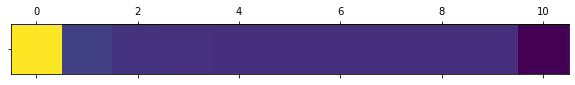


TOKEN	--->	WORDS
1	--->	<start>
5	--->	s
21	--->	eh
11	--->	v
10	--->	ah
3	--->	n
2	--->	<end>


In [37]:
# testing with test wave data
index = [i for i in np.random.randint(len(wav_tensor_val), size=1)]
print(f"Index: {index}")
test_wave = wav_tensor_val[index]
test_phoneme = phoneme_tensor_val[index, :]

max_input_length = sample_output.shape[1]
max_output_length = test_phoneme.shape[1] - 1 # minus the '<start>' since it won't show up in prediction

translate(test_wave, max_input_length, max_output_length, phoneme_tokenizer)
for tensor in test_phoneme:
    preprocesser.show_convert(tensor, phoneme_tokenizer)

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_tensor = np.array([label for label in label_tensor])
label_tensor_val = np.array([label for label in label_tensor_val])
le = LabelEncoder().fit(label_tensor)
print(f"Classes: {le.classes_}")
print(f"Classes integer: {le.transform(le.classes_)}")

labels = le.transform(label_tensor)
# labels_val = le.transform(label_tensor_val)

In [ ]:
start = time.time()

total_iter = len(wav_tensor)
pred_id = np.zeros((total_iter, max_output_length))
for i in range(total_iter):
    _, IDs, _ = predict(wav_tensor[i], max_input_length, max_output_length, phoneme_tokenizer)
    pred_id[i] = IDs.astype(np.int32)
    
    time_consumed = (time.time() - start) / 60
    print("predicting {}th wave tensor - time {:.2f} min".format(i+1, time_consumed), end="\r")

In [ ]:
start = time.time()

total_iter_val = len(wav_tensor_val)
pred_id_val = np.zeros((total_iter_val, max_output_length))
for i in range(total_iter_val):
    _, IDs, _ = predict(wav_tensor_val[i], max_input_length, max_output_length, phoneme_tokenizer)
    pred_id_val[i] = IDs.astype(np.int32)
    
    time_consumed = (time.time() - start) / 60
    print("predicting {}th wave tensor - time {:.2f} min".format(i+1, time_consumed), end="\r")

In [ ]:
# max_output_length = 6
phoneme2label = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(phoneme_tokenizer.word_index)+1, 256), 
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(10, activation="softmax"),
])

phoneme2label.compile(loss='sparse_categorical_crossentropy', 
                      optimizer='adam', 
                      metrics=['accuracy'])

phoneme2label.summary()

In [ ]:
print(f"Input:\n {pred_id}")
print()
print(f"Target:\n {labels}")

In [ ]:
history = phoneme2label.fit(pred_id, 
                            labels, 
                            epochs=5, 
                            validation_split=0.2, 
                            shuffle=True)

In [ ]:
def AccLossPlot(TrainHistory):    
    acc = TrainHistory.history['accuracy']
    val_acc = TrainHistory.history['val_accuracy']

    loss = TrainHistory.history['loss']
    val_loss = TrainHistory.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [ ]:
AccLossPlot(history)

In [ ]:
# predict the labels
pred_label = np.argmax(phoneme2label.predict(pred_id_val), 1)

# plot the confusion
pred_label = le.inverse_transform(pred_label)
label_tensor_val = label_tensor_val.reshape(label_tensor_val.shape[0], )

In [ ]:
from scikitplot.metrics import plot_confusion_matrix

plot_confusion_matrix(y_true=label_tensor_val, 
                      y_pred=pred_label, 
                      labels=None, 
                      true_labels=None, 
                      pred_labels=None, 
                      title="Linear Discriminant Analysis Confusion Matrix", 
                      normalize=False, 
                      hide_zeros=False, 
                      hide_counts=False, 
                      x_tick_rotation=0, 
                      ax=None, 
                      figsize=(10, 10), 
                      cmap='Blues', 
                      title_fontsize='large', 
                      text_fontsize='medium')

## Testing data collected from classmates

In [ ]:
SAMPLE_RATE = 16000

test_audio_path = "testing"
phoneme_path = os.path.join(os.getcwd(), "Phonemes")
phoneme_dataframe = pd.read_csv(os.path.join(phoneme_path, "phonemes.csv"))

test_reader = WaveReader(path=test_audio_path, 
                         sample_rate=SAMPLE_RATE, 
                         padding_type=None, 
                         read_size=None)

wav_array_test, label_array_test, total_test, loss_test = test_reader.read(labels=phoneme_dataframe.words)

In [ ]:
MIN_BINDING_SIZE = 1
MAX_BINDING_SIZE = 1

preprocesser = Preprocesser(min_sz=MIN_BINDING_SIZE, 
                            max_sz=MAX_BINDING_SIZE, 
                            padding_type="white_noise")

test_wave = preprocesser.simulate_wave(wav_array_test)
test_label = preprocesser.simulate_label(label_array_test)
test_phoneme = preprocesser.simulate_phoneme(labels=test_label, 
                                             label_dict=phoneme_dataframe.words.values, 
                                             phoneme_dict=phoneme_dataframe.phonemes.values)

print(f"\nExample Label Display: {test_label[0]}")
print(f"Example Phoneme Display: {test_phoneme[0]}")

In [ ]:
mfcced_test_wave = mfcc_applier.apply(test_wave, sample_rate=SAMPLE_RATE)
print("Simulated MFCC wave: (input size, time steps, MFCC dimension) {}".format(mfcced_test_wave.shape))

In [ ]:
wav_tensor_test = tf.convert_to_tensor(mfcced_test_wave, dtype=tf.float32)

# must use the same tokenizer
phoneme_tensor_test = phoneme_tokenizer.texts_to_sequences(test_phoneme)
phoneme_tensor_test = tf.keras.preprocessing.sequence.pad_sequences(phoneme_tensor_test, padding='post')

print("Input Shape: {}".format(wav_tensor_test.shape))
print("Output Shape: {}".format(phoneme_tensor_test.shape))

for tensor in phoneme_tensor_test[:1]:
    preprocesser.show_convert(tensor, phoneme_tokenizer)
    print()

In [ ]:
# testing with test wave data
# index = [i for i in np.random.randint(len(wav_tensor_test), size=1)]
index = [14]
print(f"Index: {index}")
test_wave = wav_tensor_test[index]
test_phoneme = phoneme_tensor_test[index, :]

max_input_length = sample_output.shape[1]
max_output_length = test_phoneme.shape[1] - 1 # minus the '<start>' since it won't show up in prediction

translate(test_wave, max_input_length, max_output_length, phoneme_tokenizer)
for tensor in test_phoneme:
    preprocesser.show_convert(tensor, phoneme_tokenizer)

In [ ]:
start = time.time()

total_iter = len(wav_tensor_test)
pred_id_test = np.zeros((total_iter, max_output_length))
for i in range(total_iter):
    _, IDs, _ = predict(wav_tensor_test[i], max_input_length, max_output_length, phoneme_tokenizer)
    pred_id_test[i] = IDs.astype(np.int32)
    
    time_consumed = (time.time() - start) / 60
    print("predicting {}th wave tensor - time {:.2f} min".format(i+1, time_consumed), end="\r")

# time_consumed = (time.time() - start) / 60
# print("\nTime Consumed: {:.2f} min".format(time_consumed))

In [ ]:
# predict label from phonemes
pred_label_test = np.argmax(phoneme2label.predict(pred_id_test), 1)
pred_label_test = le.inverse_transform(pred_label_test)

# true test label
test_label = np.array([label for label in test_label])
test_label = test_label.reshape(test_label.shape[0], )

In [ ]:
count = 0
for i in range(len(pred_label_test)):
    if pred_label_test[i] == test_label[i]:
        count += 1
        
count /= len(pred_label_test)
print("Testing Accuracy: {:.4f}".format(count))

In [ ]:
# plot the confusion
plot_confusion_matrix(y_true=test_label, 
                      y_pred=pred_label_test, 
                      labels=None, 
                      true_labels=None, 
                      pred_labels=None, 
                      title="Linear Discriminant Analysis Confusion Matrix", 
                      normalize=False, 
                      hide_zeros=False, 
                      hide_counts=False, 
                      x_tick_rotation=0, 
                      ax=None, 
                      figsize=(10, 10), 
                      cmap='Blues', 
                      title_fontsize='large', 
                      text_fontsize='medium')

### figure out single speech

In [ ]:
def plot_wave(samples, sample_rate=16000):
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(211)
    ax1.set_title('Raw wave of ' + '../input/train/audio/yes/0a7c2a8d_nohash_0.wav')
    ax1.set_xlabel('time')
    ax1.set_ylabel('Amplitude')
    ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

In [ ]:
index = 13

test_wave = wav_array_test[index]
test_label = label_array_test[index]
test_phoneme = "<start> " + preprocesser.phoneme_translator(test_label) + " <end>"

mfcced_test_wave = mfcc_applier.apply(test_wave[np.newaxis, :], sample_rate=SAMPLE_RATE)
wav_tensor_test = tf.convert_to_tensor(mfcced_test_wave, dtype=tf.float32)

phoneme_tensor_test = phoneme_tokenizer.texts_to_sequences(test_phoneme)
phoneme_tensor_test = tf.keras.preprocessing.sequence.pad_sequences(phoneme_tensor_test, padding='post')

In [ ]:
max_input_length = sample_output.shape[1]
max_output_length = 7 - 1 # minus the '<start>' since it won't show up in prediction

print("Real Phonemes: {}".format(test_phoneme))
plot_wave(test_wave)
translate(wav_tensor_test[0], max_input_length, max_output_length, phoneme_tokenizer)

ipd.Audio(test_wave, rate=SAMPLE_RATE)